<a href="https://colab.research.google.com/github/wiatrak2/BScThesis/blob/master/SVHNvsMnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('BScThesis/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip3 install torch torchvision

    100% |████████████████████████████████| 519.5MB 30kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x59540000 @  0x7f7a8833a2a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070
    100% |████████████████████████████████| 61kB 15.0MB/s 
    100% |████████████████████████████████| 2.0MB 5.5MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [3]:
!git clone https://github.com/wiatrak2/BScThesis

Cloning into 'BScThesis'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 239 (delta 31), reused 35 (delta 13), pack-reused 179
Receiving objects: 100% (239/239), 18.27 MiB | 14.95 MiB/s, done.
Resolving deltas: 100% (130/130), done.


In [0]:
from importlib import reload 

In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [0]:
import torchvision
import torchvision.transforms as transforms

In [0]:
import matplotlib.pyplot as plt
import pickle
import sympy
from collections import defaultdict, namedtuple
import copy

In [0]:
from mnist_m import Mnist_M
import datasets_merge
import models
import svhn_models
import trainer
import domain_trainer
from test_model import test_model
import plots
import test

In [0]:
def convertMnist(img):
  img = img.squeeze().numpy()
  return torch.from_numpy(np.tile(img, (3,1,1)))

In [0]:
batch_size=128
num_workers=1

In [11]:
mnist_transform=transforms.Compose([
                           transforms.Resize((32,32)),    
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,0.1307,0.1307), (0.3081,0.3081,0.3081)),
                           transforms.Lambda(convertMnist)
                       ])

mnist_train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True,
                                     transform=mnist_transform)
mnist_train_loader = torch.utils.data.DataLoader(mnist_train_set, batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)

mnist_test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True,
                                     transform=mnist_transform)
mnist_test_loader = torch.utils.data.DataLoader(mnist_test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)



Processing...
Done!


In [0]:
def printMnist3D(image):
  image = image.numpy()
  image = image * 0.3081 + 0.1307
  plt.imshow(image.transpose(1,2,0), cmap='gray')

4


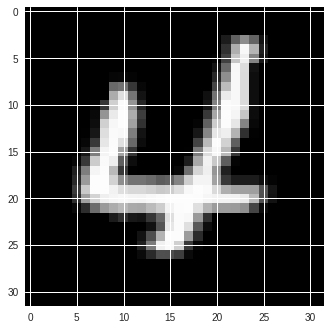

In [13]:
trainiter = iter(mnist_train_loader)
images, labels = trainiter.next()

sample = images[0]
printMnist3D(sample)
print(labels[0].item())

In [14]:
svhn_transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,0.1307,0.1307), (0.3081,0.3081,0.3081))
                       ])

svhn_train_set = torchvision.datasets.SVHN(root='./data', download=True,
                                     transform=svhn_transform)
svhn_train_loader = torch.utils.data.DataLoader(svhn_train_set, batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)

svhn_test_set = torchvision.datasets.SVHN(root='./data',  download=True,
                                     transform=svhn_transform)
svhn_test_loader = torch.utils.data.DataLoader(svhn_test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)




Using downloaded and verified file: ./data/train_32x32.mat


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f6e016d3128>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.6/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  Fil

5


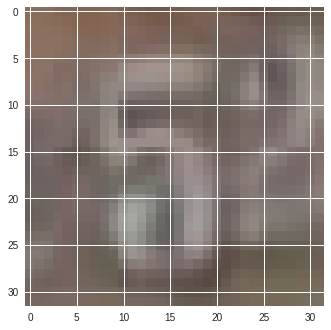

In [15]:
trainiter = iter(svhn_train_loader)
images, labels = trainiter.next()

sample = images[0]
printMnist3D(sample)
print(labels[0].item())

In [0]:
merge_train_set = datasets_merge.Merge_Datasets([mnist_train_set, svhn_train_set], get_labels=False)
merge_test_set = datasets_merge.Merge_Datasets([mnist_test_set, svhn_test_set], get_labels=False)
merge_train_loader = torch.utils.data.DataLoader(merge_train_set, 
                                                   batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)
merge_test_loader = torch.utils.data.DataLoader(merge_test_set, 
                                                   batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)

In [0]:
log_interval = 100

In [0]:
use_cuda = True
use_cuda = use_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [0]:
lr = 0.01
momentum=0.9

In [0]:
Models = namedtuple('Models', ['model_f', 'model_c', 'model_d'])
Optims = namedtuple('Optims', ['optim_f', 'optim_c', 'optim_d'])
Criterions = namedtuple('Criterions', ['criterion', 'criterion_domain'])
Loaders = namedtuple('Loaders', ['train_loader', 'train_loader_domain',
                                'source_test_loader', 'target_test_loader',
                                'merged_test_loader'])

In [0]:
loaders = Loaders(svhn_train_loader, mnist_train_loader, 
                 svhn_test_loader, mnist_test_loader, merge_test_loader)

In [0]:
criterion = F.nll_loss
criterion_domain = F.nll_loss

In [0]:
criterions = Criterions(criterion, criterion_domain)

In [0]:
epochs=10

In [0]:
model_f = svhn_models.SvhnFeatureExtractor([3,48, 64, 128, 160, 192], pool_stride=2, pool_padding=1).to(device)

In [26]:
output_size = model_f.get_output_size(device)[1]
output_size

768

In [0]:
mf = [output_size]
mc = [output_size, 3072, 2048, 512]
md = [output_size, 1024, 100]

In [0]:
_, model_c, model_d = models.get_models(mf, mc, md, use_gr=True)
model_f, model_c, model_d = model_f.to(device), model_c.to(device), model_d.to(device)

In [0]:
lr=0.01
optim_f = optim.SGD(model_f.parameters(), lr=lr, momentum=momentum)
optim_c = optim.SGD(model_c.parameters(), lr=lr, momentum=momentum)
optim_d = optim.SGD(model_d.parameters(), lr=lr, momentum=momentum)

In [0]:
train_models = Models(model_f, model_c, model_d)
optims = Optims(optim_f, optim_c, optim_d)

In [0]:
model_trainer_gr = trainer.Trainer(train_models, optims, criterions, device, train_domain=True, tune_lr=True)

In [32]:
test_history_gr = defaultdict(lambda:[])
model_trainer_gr.train(14, loaders, test_history=test_history_gr)

Train Epoch: 					1 [0/73257 (0%)]	Loss: 2.308405, lr: 0.01000 lambd: 0.00000
Train Epoch: 					1 [12800/73257 (17%)]	Loss: 2.174871, lr: 0.00916 lambd: 0.06232
Train Epoch: 					1 [25600/73257 (35%)]	Loss: 2.279665, lr: 0.00846 lambd: 0.12416
Train Epoch: 					1 [38400/73257 (52%)]	Loss: 2.230845, lr: 0.00788 lambd: 0.18505
Train Epoch: 					1 [51200/73257 (70%)]	Loss: 2.090456, lr: 0.00738 lambd: 0.24455

Target Domain Test set: Average loss: 2.2015, Accuracy: 1797/10000 (18%)
Source Domain Test set: Average loss: 2.1697, Accuracy: 18492/73257 (25%)
Domains predictor:  Accuracy: 48970/83257 (59%)

Train Epoch: 					2 [0/73257 (0%)]	Loss: 2.172054, lr: 0.00667 lambd: 0.34269
Train Epoch: 					2 [12800/73257 (17%)]	Loss: 2.098871, lr: 0.00633 lambd: 0.39655
Train Epoch: 					2 [25600/73257 (35%)]	Loss: 2.078905, lr: 0.00603 lambd: 0.44780
Train Epoch: 					2 [38400/73257 (52%)]	Loss: 1.934986, lr: 0.00576 lambd: 0.49627
Train Epoch: 					2 [51200/73257 (70%)]	Loss: 1.835333, lr: 0.0055

In [33]:
model_trainer_gr.train(4, loaders, test_history=test_history_gr)

Train Epoch: 					1 [0/73257 (0%)]	Loss: 0.393037, lr: 0.01000 lambd: 0.00000
Train Epoch: 					1 [12800/73257 (17%)]	Loss: 0.347366, lr: 0.00762 lambd: 0.21500
Train Epoch: 					1 [25600/73257 (35%)]	Loss: 0.429173, lr: 0.00624 lambd: 0.41100
Train Epoch: 					1 [38400/73257 (52%)]	Loss: 0.256395, lr: 0.00534 lambd: 0.57518
Train Epoch: 					1 [51200/73257 (70%)]	Loss: 0.539041, lr: 0.00469 lambd: 0.70322


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f6e0126bb38>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.6/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  Fil


Target Domain Test set: Average loss: 1.1768, Accuracy: 6559/10000 (66%)
Source Domain Test set: Average loss: 0.5379, Accuracy: 61216/73257 (84%)
Domains predictor:  Accuracy: 27462/83257 (33%)

Train Epoch: 					2 [0/73257 (0%)]	Loss: 0.490688, lr: 0.00391 lambd: 0.84828
Train Epoch: 					2 [12800/73257 (17%)]	Loss: 0.313137, lr: 0.00358 lambd: 0.89927
Train Epoch: 					2 [25600/73257 (35%)]	Loss: 0.475707, lr: 0.00331 lambd: 0.93374
Train Epoch: 					2 [38400/73257 (52%)]	Loss: 0.437520, lr: 0.00308 lambd: 0.95668
Train Epoch: 					2 [51200/73257 (70%)]	Loss: 0.304573, lr: 0.00288 lambd: 0.97180

Target Domain Test set: Average loss: 1.0352, Accuracy: 6883/10000 (69%)
Source Domain Test set: Average loss: 0.4289, Accuracy: 63756/73257 (87%)
Domains predictor:  Accuracy: 15808/83257 (19%)

Train Epoch: 					3 [0/73257 (0%)]	Loss: 0.287428, lr: 0.00261 lambd: 0.98661
Train Epoch: 					3 [12800/73257 (17%)]	Loss: 0.389204, lr: 0.00247 lambd: 0.99133
Train Epoch: 					3 [25600/73257 (3

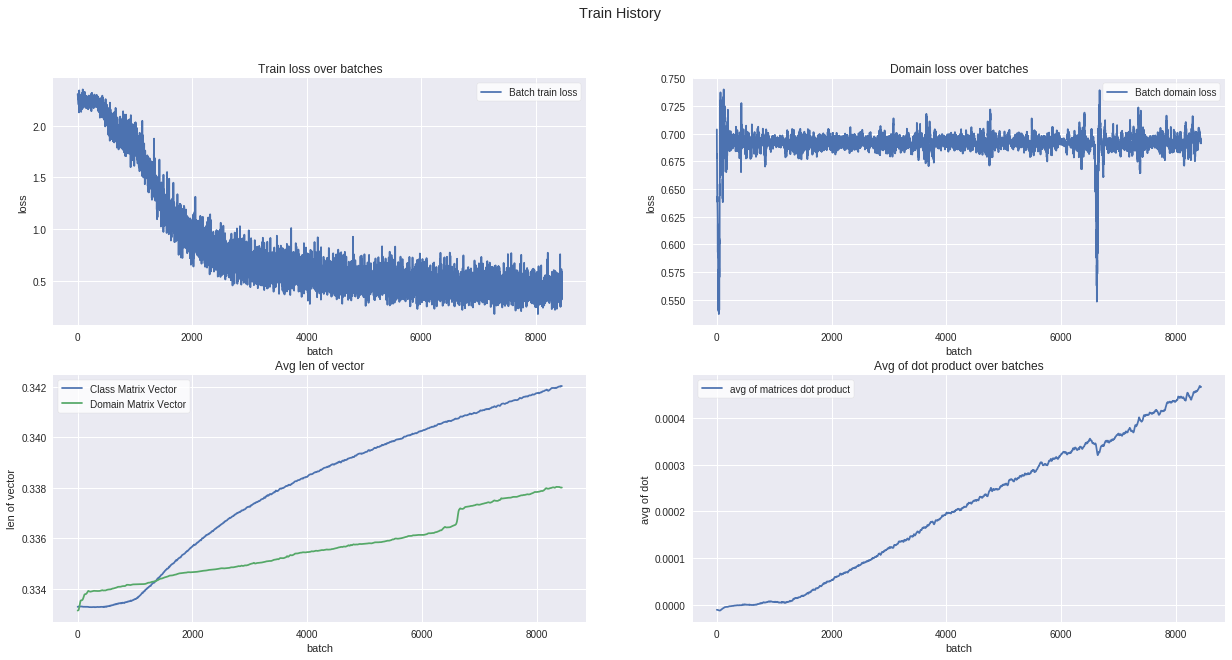

In [34]:
plots.plot_training(model_trainer_gr.train_history)

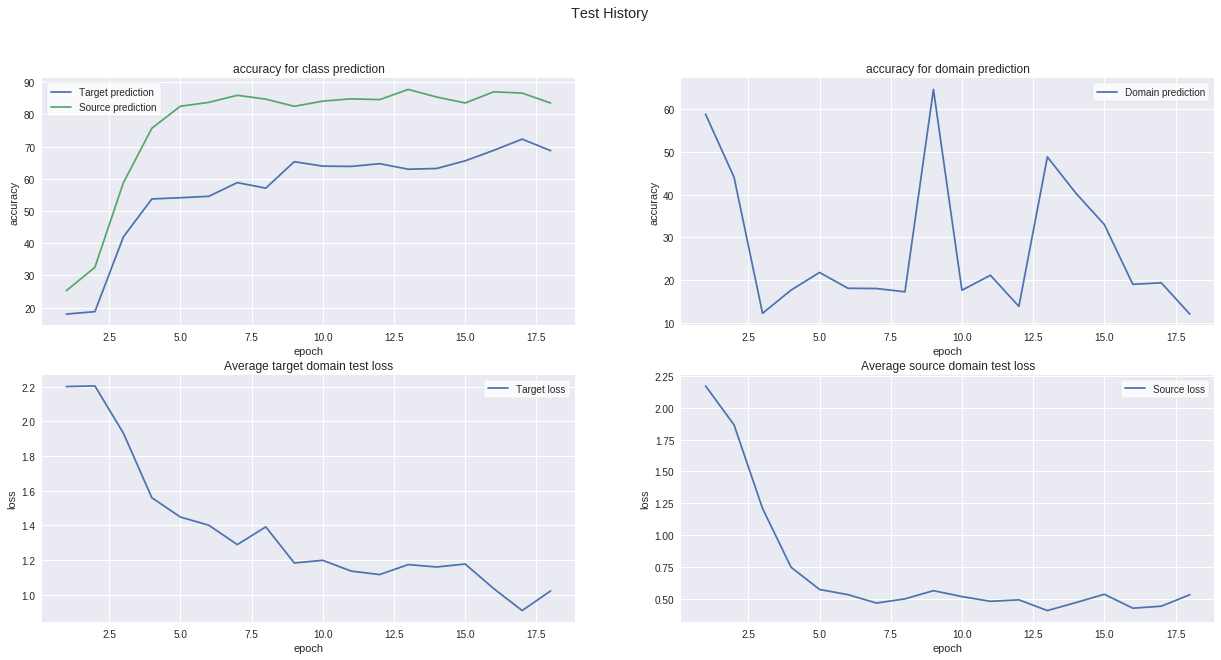

In [36]:
plots.plot_test(test_history_gr)

In [0]:
_, _, domain_pred = models.get_models(mf, mc, md, use_gr=False)
domain_pred = domain_pred.to(device)

In [0]:
domain_optim = optim.SGD(domain_pred.parameters(), lr=lr, momentum=momentum)

In [0]:
models_dom = Models(model_f, None, domain_pred)
optims_dom = Optims(None, None, optim_d=domain_optim)
new_domain_trainer = domain_trainer.DomainTrainer(models_dom, optims_dom, criterions, device)

In [100]:
domain_train_history = defaultdict(lambda:[])
new_domain_trainer.train(2, loaders, train_models, train_history=domain_train_history)

Train Epoch: 1 [0/83257 (0%)]	Loss: 0.684113
Train Epoch: 1 [12800/83257 (15%)]	Loss: 0.023551
Train Epoch: 1 [25600/83257 (31%)]	Loss: 0.001277
Train Epoch: 1 [38400/83257 (46%)]	Loss: 0.001570
Train Epoch: 1 [51200/83257 (61%)]	Loss: 0.000904
Train Epoch: 1 [64000/83257 (77%)]	Loss: 0.000775
Train Epoch: 1 [76800/83257 (92%)]	Loss: 0.000499

Domains predictor:  Accuracy: 83251/83257 (100%)

Train Epoch: 2 [0/83257 (0%)]	Loss: 0.000545
Train Epoch: 2 [12800/83257 (15%)]	Loss: 0.000268
Train Epoch: 2 [25600/83257 (31%)]	Loss: 0.000164
Train Epoch: 2 [38400/83257 (46%)]	Loss: 0.000734
Train Epoch: 2 [51200/83257 (61%)]	Loss: 0.000373
Train Epoch: 2 [64000/83257 (77%)]	Loss: 0.000086
Train Epoch: 2 [76800/83257 (92%)]	Loss: 0.000181

Domains predictor:  Accuracy: 83254/83257 (100%)



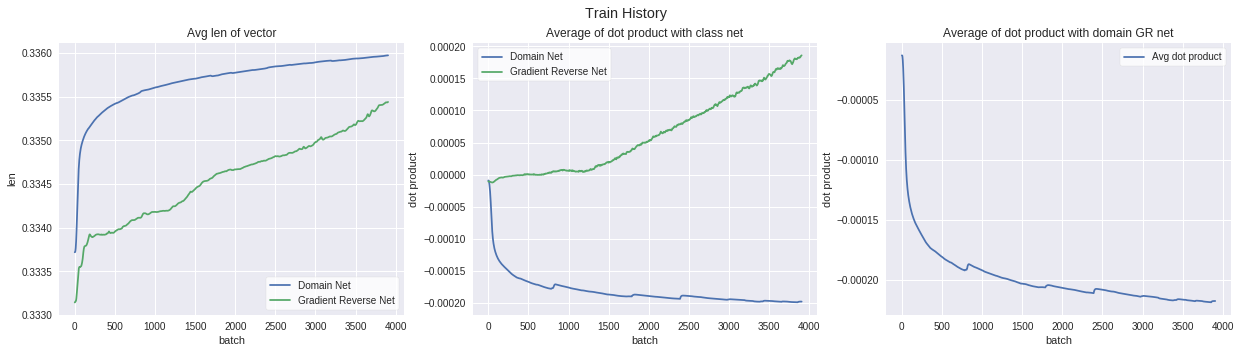

In [82]:
plots.plot_domain_training(domain_train_history, model_trainer_gr.train_history)

In [0]:
def mtx_dot(model_f, model_c, model_d, *args):
  return torch.mean(torch.pow(torch.mm(model_c.get_mtx().weight, torch.transpose(model_d.get_mtx().weight, 0, 1)), 2))

In [0]:
new_trainer = copy.deepcopy(model_trainer_gr)

In [46]:
test_history_next = defaultdict(lambda:[])
new_trainer.train(8, loaders, mtx_dot, test_history=test_history_next)

Train Epoch: 					1 [0/73257 (0%)]	Loss: 0.310666, lr: 0.01000 lambd: 0.00000
Train Epoch: 					1 [12800/73257 (17%)]	Loss: 0.458019, lr: 0.00862 lambd: 0.10877
Train Epoch: 					1 [25600/73257 (35%)]	Loss: 0.396592, lr: 0.00762 lambd: 0.21500
Train Epoch: 					1 [38400/73257 (52%)]	Loss: 0.425736, lr: 0.00685 lambd: 0.31637
Train Epoch: 					1 [51200/73257 (70%)]	Loss: 0.267207, lr: 0.00624 lambd: 0.41100


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f6dfae4f320>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.6/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  Fil


Target Domain Test set: Average loss: 1.0854, Accuracy: 6659/10000 (67%)
Source Domain Test set: Average loss: 0.4154, Accuracy: 64125/73257 (88%)
Domains predictor:  Accuracy: 27496/83257 (33%)

Train Epoch: 					2 [0/73257 (0%)]	Loss: 0.342811, lr: 0.00544 lambd: 0.55460
Train Epoch: 					2 [12800/73257 (17%)]	Loss: 0.414005, lr: 0.00508 lambd: 0.62563
Train Epoch: 					2 [25600/73257 (35%)]	Loss: 0.346587, lr: 0.00477 lambd: 0.68761
Train Epoch: 					2 [38400/73257 (52%)]	Loss: 0.537204, lr: 0.00449 lambd: 0.74096
Train Epoch: 					2 [51200/73257 (70%)]	Loss: 0.326341, lr: 0.00426 lambd: 0.78636

Target Domain Test set: Average loss: 1.0798, Accuracy: 6753/10000 (68%)
Source Domain Test set: Average loss: 0.5143, Accuracy: 61514/73257 (84%)
Domains predictor:  Accuracy: 10464/83257 (13%)

Train Epoch: 					3 [0/73257 (0%)]	Loss: 0.479018, lr: 0.00391 lambd: 0.84828
Train Epoch: 					3 [12800/73257 (17%)]	Loss: 0.335882, lr: 0.00373 lambd: 0.87621
Train Epoch: 					3 [25600/73257 (3

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f6dfae4fb38>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.6/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  Fil


Target Domain Test set: Average loss: 1.0247, Accuracy: 7005/10000 (70%)
Source Domain Test set: Average loss: 0.3203, Accuracy: 66343/73257 (91%)
Domains predictor:  Accuracy: 16107/83257 (19%)

Train Epoch: 					8 [0/73257 (0%)]	Loss: 0.338149, lr: 0.00181 lambd: 0.99968
Train Epoch: 					8 [12800/73257 (17%)]	Loss: 0.443543, lr: 0.00178 lambd: 0.99975
Train Epoch: 					8 [25600/73257 (35%)]	Loss: 0.481358, lr: 0.00175 lambd: 0.99980
Train Epoch: 					8 [38400/73257 (52%)]	Loss: 0.368085, lr: 0.00173 lambd: 0.99984
Train Epoch: 					8 [51200/73257 (70%)]	Loss: 0.278446, lr: 0.00170 lambd: 0.99987

Target Domain Test set: Average loss: 0.9731, Accuracy: 7170/10000 (72%)
Source Domain Test set: Average loss: 0.4059, Accuracy: 63964/73257 (87%)
Domains predictor:  Accuracy: 33233/83257 (40%)



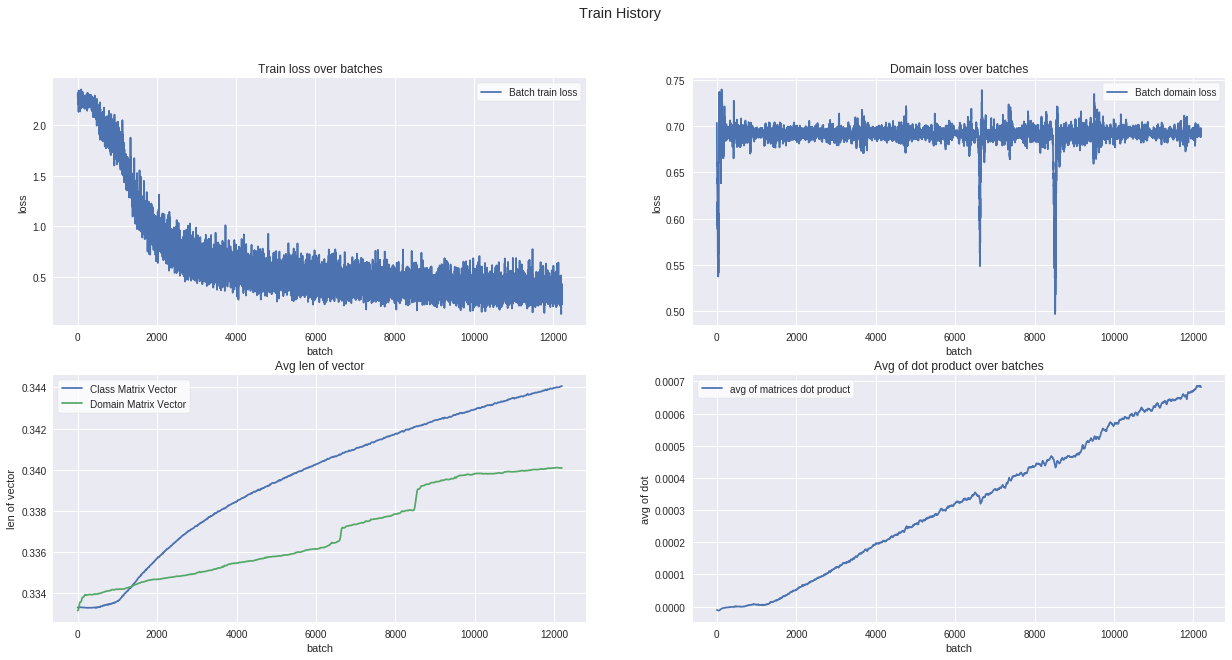

In [47]:
plots.plot_training(new_trainer.train_history)

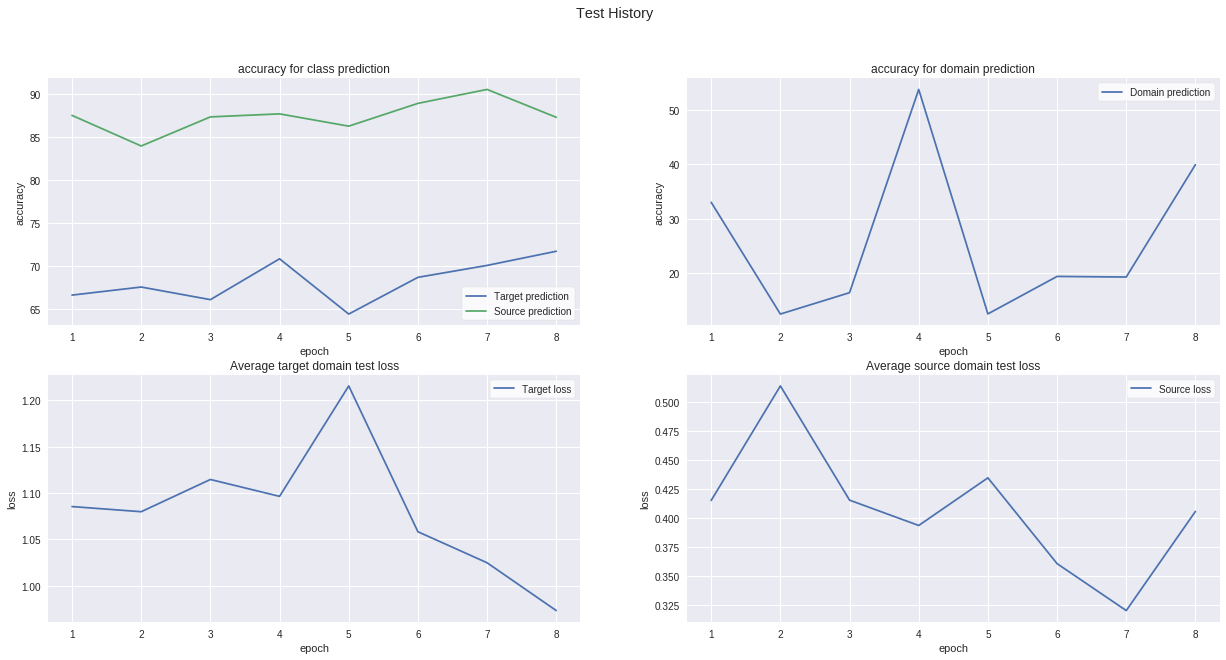

In [52]:
plots.plot_test(test_history_next)

In [0]:
_, _, domain_pred_gr = models.get_models(mf, mc, md, use_gr=True)
domain_pred_gr.load_state_dict(domain_pred.state_dict())
domain_pred_gr = domain_pred_gr.to(device)
new_optim_d = optim.SGD(domain_pred_gr.parameters(), lr=lr, momentum=momentum, nesterov=True)

In [102]:
dom_pr = nn.Sequential(model_f, domain_pred_gr)
domain_trainer.DomainTrainer.test_domain_pred(dom_pr, device, merge_test_loader)


Domains predictor:  Accuracy: 83254/83257 (100%)



In [0]:
new_domain_train_models = Models(model_f, model_c, domain_pred_gr)
new_domain_train_optims = Optims(optim_f, optim_c, new_optim_d)

In [0]:
domain_trainer_gr = trainer.Trainer(new_domain_train_models, new_domain_train_optims, criterions, device, tune_lr=True)

In [105]:
test_history_dom_gr = defaultdict(lambda:[])
domain_trainer_gr.train(5, loaders, test_history=test_history_dom_gr)

Train Epoch: 					1 [0/73257 (0%)]	Loss: 0.333276, lr: 0.01000 lambd: 0.00000
Train Epoch: 					1 [12800/73257 (17%)]	Loss: 0.649215, lr: 0.00799 lambd: 0.17297
Train Epoch: 					1 [25600/73257 (35%)]	Loss: 0.374981, lr: 0.00672 lambd: 0.33589
Train Epoch: 					1 [38400/73257 (52%)]	Loss: 0.441590, lr: 0.00584 lambd: 0.48092
Train Epoch: 					1 [51200/73257 (70%)]	Loss: 0.373454, lr: 0.00519 lambd: 0.60368

Target Domain Test set: Average loss: 1.1471, Accuracy: 6633/10000 (66%)
Source Domain Test set: Average loss: 0.7091, Accuracy: 56190/73257 (77%)
Domains predictor:  Accuracy: 270/83257 (0%)

Train Epoch: 					2 [0/73257 (0%)]	Loss: 0.267832, lr: 0.00439 lambd: 0.76159
Train Epoch: 					2 [12800/73257 (17%)]	Loss: 0.297972, lr: 0.00404 lambd: 0.82578
Train Epoch: 					2 [25600/73257 (35%)]	Loss: 0.373723, lr: 0.00375 lambd: 0.87392
Train Epoch: 					2 [38400/73257 (52%)]	Loss: 0.730137, lr: 0.00350 lambd: 0.90942
Train Epoch: 					2 [51200/73257 (70%)]	Loss: 0.464718, lr: 0.00329 l

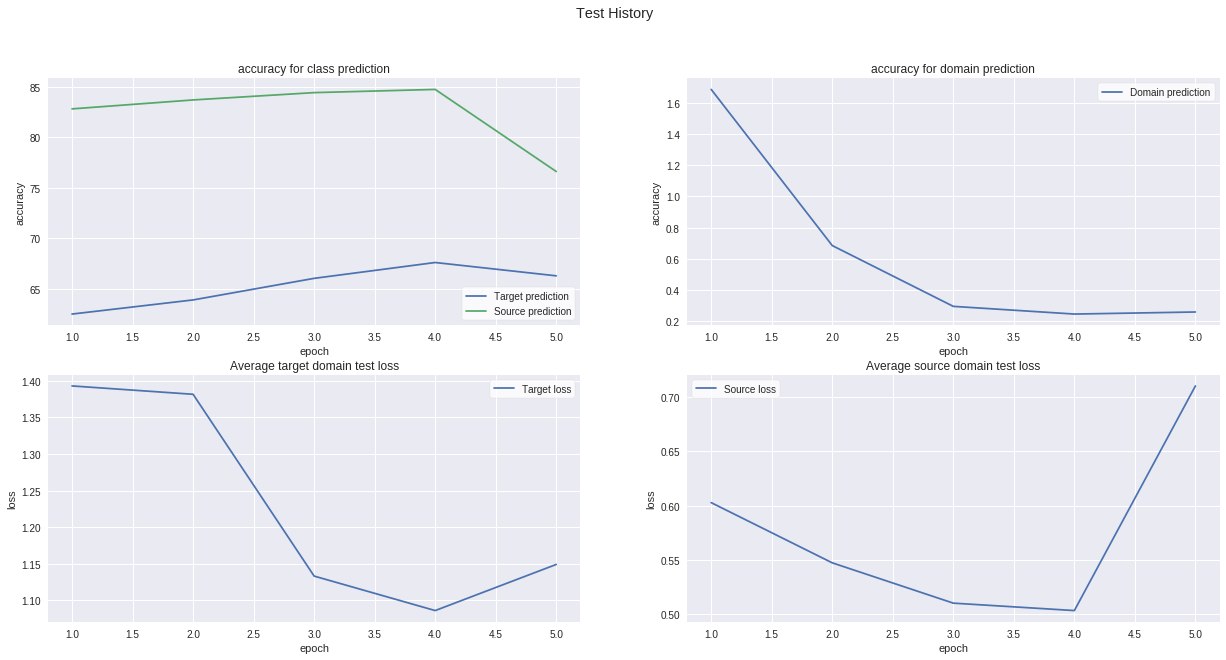

In [74]:
plots.plot_test(test_history_dom_gr)

In [0]:
def test_domain(test_models, loaders, criterions, device, epochs):
  input_size = test_models.model_c.get_mtx().weight.size()[1]
  domain_pred = models.DomainPredictor(input_size=input_size).to(device)
  domain_optim = optim.Adam(domain_pred.parameters(), lr=lr)
  models_dom = Models(test_models.model_f, None, domain_pred)
  optims_dom = Optims(None, None, optim_d=domain_optim)
  mnist_domain_trainer = domain_trainer.DomainTrainer(models_dom, optims_dom, criterions, device, print_logs=False)
  domain_train_history = defaultdict(lambda:[])
  mnist_domain_trainer.train(epochs, loaders, None, train_history=domain_train_history)
  return domain_train_history

In [0]:
def get_next_models(train_models, device, freeze_model=True):
  if len(train_models.model_c.linears) == 0:
    return Models(None, None, None)
  model_c_f, model_c_c = train_models.model_c.split(1)
  model_c_f, model_c_c = model_c_f.to(device), model_c_c.to(device)
  new_model_f, input_size = models.extend_feature_extractor(train_models.model_f, model_c_f,
                                                           freeze_model=freeze_model)
  new_model_f=new_model_f.to(device)
  model_d = models.MnistDomain(input_size=input_size).to(device)
  return Models(new_model_f, model_c_c, model_d)

In [0]:
def domain_vainshing_research(train_models, optims, loaders, criterions,device,
                              epochs, freeze_model=True, print_test=True, extra_loss=None, tune_lr=True):
  trainers = []
  tests_histories = []
  domain_histories = []
  domain_gr_histories = []
  model_c_len = len(model_c.linears)
  while train_models.model_c is not None:
    domain_gr_histories.append(test_domain(train_models, loaders, criterions, device, epochs))
    if print_test:
      print('Model_c layers: {} Domain prediction on Feature Extractor after GR: {}'.format(
             model_c_len+1, domain_gr_histories[-1]['acc']))
    
    train_models = get_next_models(train_models, device, freeze_model=freeze_model)
    model_c_len -= 1
    if model_c_len < 0:
      break
    domain_histories.append(test_domain(train_models, loaders, criterions, device, epochs))    
    if print_test:
      print("Domain prediction on Class Predictor's first layer",
            domain_histories[-1]['acc'])    
    
    optim_f = optim.Adam(train_models.model_f.parameters(), lr=lr)
    optim_c = optim.Adam(train_models.model_c.parameters(), lr=lr)
    optim_d = optim.Adam(train_models.model_d.parameters(), lr=lr)
    optims = Optims(optim_f, optim_c, optim_d)    
    trainers.append(trainer.Trainer(train_models, optims, criterions, device, tune_lr=tune_lr, print_logs=False))
    tests_histories.append(defaultdict(lambda:[]))
    trainers[-1].train(epochs, loaders, extra_loss=extra_loss, test_history=tests_histories[-1])
    if print_test:
      print("Model_c layers: {} Model Accuracy with GR on Class Predictor's first layer: {}".format(
            model_c_len+1, tests_histories[-1]['target_acc']))

  return trainers, tests_histories, domain_histories, domain_gr_histories

In [0]:
domain_vanish_models = copy.deepcopy(model_trainer_gr.best_model)
optim_f = optim.SGD(domain_vanish_models.model_f.parameters(), lr=lr, momentum=momentum, nesterov=True)
optim_c = optim.SGD(domain_vanish_models.model_c.parameters(), lr=lr, momentum=momentum, nesterov=True)
optim_d = optim.SGD(domain_vanish_models.model_d.parameters(), lr=lr, momentum=momentum, nesterov=True)


In [0]:
optims = Optims(optim_f, optim_c, optim_d)

In [72]:
trainers, test_histories, domain_histories, domain_gr_histories = domain_vainshing_research(domain_vanish_models, optims, loaders, criterions, device, epochs)

Model_c layers: 4 Domain prediction on Feature Extractor after GR: [99.72014365158485, 99.60724023205256, 99.83544927153272, 99.90391198337677, 99.81142726737691, 99.9123196848313, 99.9003086827534, 99.91952628607805, 99.91712408566246, 99.90271088316898]
Domain prediction on Class Predictor's first layer [99.69131724659789, 99.54478302124747, 99.58562042831234, 99.6024358312214, 99.85346577464958, 99.71894255137705, 99.83424817132493, 99.92673288732479, 99.88709658046771, 99.71654035096148]
Model_c layers: 3 Model Accuracy with GR on Class Predictor's first layer: [58.7, 60.74, 59.6, 61.08, 51.59, 61.06, 57.82, 60.99, 65.78, 58.13]
Model_c layers: 3 Domain prediction on Feature Extractor after GR: [88.07307493664196, 88.22561466303134, 87.99260122272001, 88.02022652749919, 87.99260122272001, 91.66796785855844, 91.54185233674045, 91.05780895300094, 89.39548626541912, 91.74123497123365]
Domain prediction on Class Predictor's first layer [90.1701958994439, 93.10568480728347, 93.470819270

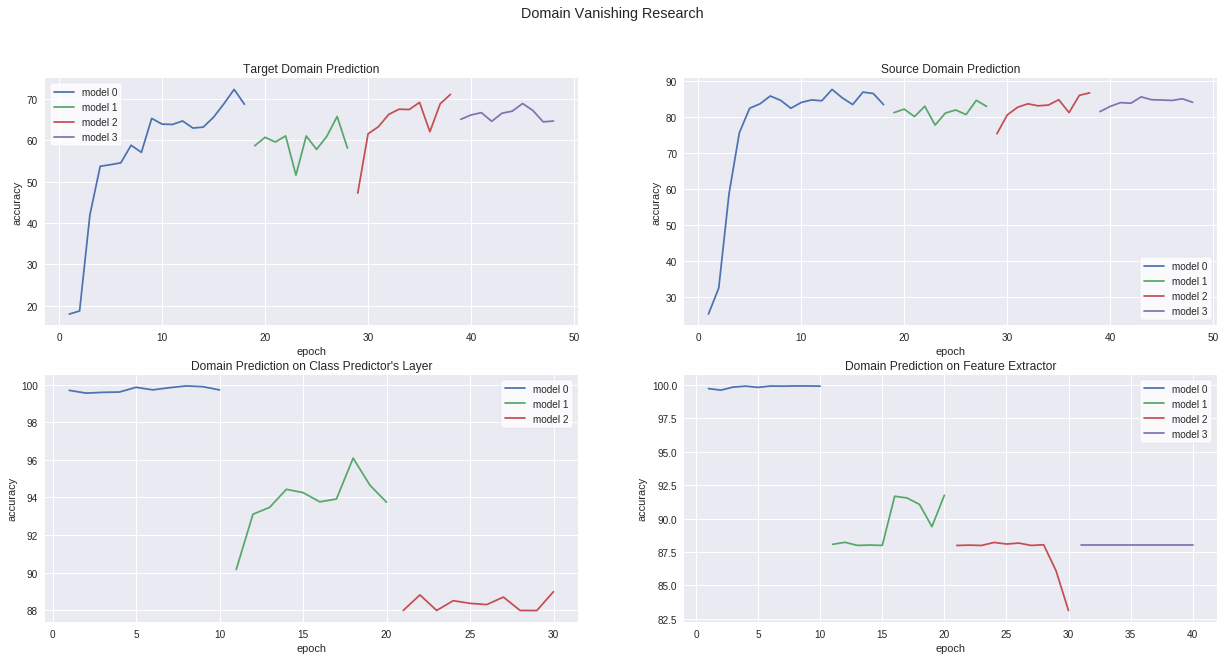

In [73]:
plots.plot_domain_vanishing([model_trainer_gr] + trainers, [test_history_gr] + test_histories, domain_histories, domain_gr_histories)

In [0]:
model_f = svhn_models.SvhnFeatureExtractor([3,48, 64, 128, 160, 192], pool_stride=2, pool_padding=1).to(device)

In [0]:
output_size = model_f.get_output_size(device)[1]

In [0]:
mf = [output_size]
mc = [output_size, 3072, 2048, 512]
md = [output_size, 1024, 100]

In [0]:
_, model_c, model_d = models.get_models(mf, mc, md, use_gr=True)
model_f, model_c, model_d = model_f.to(device), model_c.to(device), model_d.to(device)

In [0]:
optim_f = optim.SGD(model_f.parameters(), lr=lr, momentum=momentum, nesterov=True)
optim_c = optim.SGD(model_c.parameters(), lr=lr, momentum=momentum, nesterov=True)
optim_d = optim.SGD(model_d.parameters(), lr=lr, momentum=momentum, nesterov=True)

In [0]:
train_models = Models(model_f, model_c, model_d)
optims = Optims(optim_f, optim_c, optim_d)

In [0]:
model_trainer_gr = Trainer(train_models, optims, criterions, device, train_domain=True, tune_lr=True)

In [114]:
test_history_gr = defaultdict(lambda:[])
model_trainer_gr.train(16, loaders, test_history=test_history_gr)

Train Epoch: 					1 [0/73257 (0%)]	Loss: 2.311474, lr: 0.01000 lambd: 0.00000
Train Epoch: 					1 [12800/73257 (17%)]	Loss: 2.332980, lr: 0.00925 lambd: 0.05455
Train Epoch: 					1 [25600/73257 (35%)]	Loss: 2.250680, lr: 0.00862 lambd: 0.10877
Train Epoch: 					1 [38400/73257 (52%)]	Loss: 2.214403, lr: 0.00809 lambd: 0.16236
Train Epoch: 					1 [51200/73257 (70%)]	Loss: 2.193475, lr: 0.00762 lambd: 0.21500

Target Domain Test set: Average loss: 2.1754, Accuracy: 1795/10000 (18%)
Source Domain Test set: Average loss: 2.1113, Accuracy: 19961/73257 (27%)
Domains predictor:  Accuracy: 52059/83257 (63%)

Train Epoch: 					2 [0/73257 (0%)]	Loss: 2.092833, lr: 0.00695 lambd: 0.30271
Train Epoch: 					2 [12800/73257 (17%)]	Loss: 1.848027, lr: 0.00662 lambd: 0.35145
Train Epoch: 					2 [25600/73257 (35%)]	Loss: 2.018963, lr: 0.00632 lambd: 0.39837
Train Epoch: 					2 [38400/73257 (52%)]	Loss: 1.956685, lr: 0.00605 lambd: 0.44328
Train Epoch: 					2 [51200/73257 (70%)]	Loss: 1.788358, lr: 0.0058

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f6df9b46e80>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.6/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  Fil


Target Domain Test set: Average loss: 1.0974, Accuracy: 6536/10000 (65%)
Source Domain Test set: Average loss: 0.4271, Accuracy: 63688/73257 (87%)
Domains predictor:  Accuracy: 19394/83257 (23%)

Train Epoch: 					16 [0/73257 (0%)]	Loss: 0.309697, lr: 0.00173 lambd: 0.99983
Train Epoch: 					16 [12800/73257 (17%)]	Loss: 0.440065, lr: 0.00172 lambd: 0.99985
Train Epoch: 					16 [25600/73257 (35%)]	Loss: 0.406393, lr: 0.00170 lambd: 0.99986
Train Epoch: 					16 [38400/73257 (52%)]	Loss: 0.453788, lr: 0.00169 lambd: 0.99988
Train Epoch: 					16 [51200/73257 (70%)]	Loss: 0.378698, lr: 0.00168 lambd: 0.99989

Target Domain Test set: Average loss: 0.9433, Accuracy: 7206/10000 (72%)
Source Domain Test set: Average loss: 0.3898, Accuracy: 64700/73257 (88%)
Domains predictor:  Accuracy: 34454/83257 (41%)

